In [1]:
import pandas as pd
## for text processing
import re
import nltk

from scipy import stats

## for sentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
## for ner
# import spacy
# ## for vectorizer
from sklearn import manifold
## for word embedding
import gensim.downloader as gensim_api
## for topic modeling
import gensim
# plotting topic model
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

/Users/cyzhu/conda/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


### Helper functions

In [2]:
def clean_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    """Preprocess the text. 
    Convert to lowercase, remove @user, remove punctuations and characters and then strip.
    """
    ## clean ()
    text = re.sub('@[^\s]+','',text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

def get_sentence_count(text):
    """Make sure that '' or whitespace doesn't count as a sentence. """
    non_empty = [i for i in text.split('.') if i or i.isspace()]
    return len(non_empty)

def get_word_stats(df,colname:str = 'Text'):
    """Get the summary stats for word count, charater count, sentence count, avg length."""
    df['word_count'] = df[colname].apply(lambda x: len(str(x).split(" ")))
    df['char_count'] = df[colname].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

    df['sentence_count'] = df[colname].apply(lambda x: get_sentence_count(x))
    df['avg_word_length'] = df['char_count'] / df['word_count']
    df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
    return df

def plot_distribution(x,category,width:int = 10, height:int = 4):
    """Plot the distribution by category."""
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (width,height))
    fig.suptitle(x, fontsize=12)
    for i in df2[category].unique():
        sns.distplot(df2[df2[category]==i][x], hist=True, kde=False, 
                    bins=10, hist_kws={"alpha":0.8}, 
                    axlabel="histogram", ax=ax[0])
        sns.distplot(df2[df2[category]==i][x], hist=False, kde=True, 
                    kde_kws={"shade":True}, axlabel="density",   
                    ax=ax[1])
    ax[0].grid(True)
    ax[0].legend(df2[category].unique())
    ax[1].grid(True)
    return fig,ax


### 1. Data profiling and preprocessing

In [3]:
df = pd.read_excel("2016 Election Random Sample.xlsx")
print(df.shape)
print(df.dtypes)
df.head(3)

(82999, 7)
Keyword       object
Handle        object
TimeStamp     object
TweetID      float64
Text          object
Followers      int64
WC             int64
dtype: object


,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC
0,Clinton,CrabbyAbbey1,Fri Oct 07 00:00:06 +0000 2016,7.841815e+17,@SarahKSilverman If you have to lie to win you...,1,16
1,Clinton,Marianne_Summer,Fri Oct 07 00:00:26 +0000 2016,7.841816e+17,Here's how much Hillary Clinton paid in taxes ...,2,11
2,Trump,SAcurrent,Fri Oct 07 00:00:32 +0000 2016,7.841816e+17,Protesters at Trump's SA Fundraiser Were Passi...,78082,11


In [4]:
df.isnull().sum()

Keyword      0
Handle       0
TimeStamp    0
TweetID      0
Text         0
Followers    0
WC           0
dtype: int64

In [5]:
# remove duplicated records
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True,drop=True)

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
# so apparently object type is not equivalent to string type
# need to explicitly transform it to str type
df['Handle'] = df['Handle'].astype(str)

print(df.shape)
print(df['TimeStamp'].min(), df['TimeStamp'].max())
df.tail(3)

(82647, 7)
2016-10-05 20:07:31+00:00 2016-10-12 23:25:22+00:00


,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC
82644,Election-General,KalonJelen,2016-10-12 23:25:17+00:00,7.863470e+17,Yeah. No one's surprised. At this point it's j...,91,24
82645,Clinton,By_SJD,2016-10-12 23:25:18+00:00,7.863470e+17,They do know that #repealthe19th just makes me...,842,27
82646,Clinton,Barbara101123,2016-10-12 23:25:22+00:00,7.863471e+17,Remember Hillary and her campaign are in Cahoo...,5,15


In [6]:
df.nunique()

Keyword          4
Handle       62012
TimeStamp    75142
TweetID      82647
Text         77628
Followers    12075
WC              26
dtype: int64

In [7]:
count_by_user = df.groupby('Handle')['TweetID'].count().reset_index()
count_by_user.sort_values(by='TweetID',ascending=False).head()

,Handle,TweetID
12796,HydroElections,118
38476,corrigan_david,82
38412,constantino_sam,61
34261,amrightnow,48
20066,MikePence20,45


In [8]:
df['Followers'].describe()

count    8.264700e+04
mean     1.148538e+04
std      3.205234e+05
min      0.000000e+00
25%      9.200000e+01
50%      4.330000e+02
75%      1.722000e+03
max      3.082208e+07
Name: Followers, dtype: float64

In [9]:
df.groupby('Keyword')['TweetID'].count()

Keyword
Both                 7052
Clinton             18999
Election-General    14734
Trump               41862
Name: TweetID, dtype: int64

In [10]:
lst_stopwords = nltk.corpus.stopwords.words("english")
# adding word 'url' to stop words
lst_stopwords.append('url')

# clean the text
df['Text_Clean'] = df['Text'].apply(lambda x: clean_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords = lst_stopwords)) 
df.head(3)

,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC,Text_Clean
0,Clinton,CrabbyAbbey1,2016-10-07 00:00:06+00:00,7.841815e+17,@SarahKSilverman If you have to lie to win you...,1,16,lie win work clinton that pretti deplor
1,Clinton,Marianne_Summer,2016-10-07 00:00:26+00:00,7.841816e+17,Here's how much Hillary Clinton paid in taxes ...,2,11,here much hillari clinton paid tax last year
2,Trump,SAcurrent,2016-10-07 00:00:32+00:00,7.841816e+17,Protesters at Trump's SA Fundraiser Were Passi...,78082,11,protest trump sa fundrais passion peac


In [11]:
print(df["Text"].iloc[0], " --> ", df["Text_Clean"].iloc[0])

@SarahKSilverman If you have to lie to win you are working for Clinton. That's pretty deplorable.  -->  lie win work clinton that pretti deplor


In [11]:
df2 = get_word_stats(df,colname='Text')
df2.head(3)

,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC,Text_Clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,Clinton,CrabbyAbbey1,2016-10-07 00:00:06+00:00,7.841815e+17,@SarahKSilverman If you have to lie to win you...,1,16,lie win work clinton that pretti deplor,16,82,2,5.125000,8.0
1,Clinton,Marianne_Summer,2016-10-07 00:00:26+00:00,7.841816e+17,Here's how much Hillary Clinton paid in taxes ...,2,11,here much hillari clinton paid tax last year,11,49,1,4.454545,11.0
2,Trump,SAcurrent,2016-10-07 00:00:32+00:00,7.841816e+17,Protesters at Trump's SA Fundraiser Were Passi...,78082,11,protest trump sa fundrais passion peac,11,62,1,5.636364,11.0


In [63]:
df2.describe()

,TweetID,Followers,WC,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,sentiment,sentiment_abs,group
count,8.264700e+04,8.264700e+04,82647.000000,82647.000000,82647.000000,82647.000000,82647.000000,82647.000000,82647.000000,82647.000000,82647.000000
mean,7.851709e+17,1.148538e+04,17.109175,17.873014,86.375138,1.619393,4.934279,13.150915,0.054578,0.171809,1.354629
std,2.802548e+15,3.205234e+05,4.489505,4.888689,20.860920,0.860497,0.890247,5.740491,0.295430,0.246453,0.495597
min,2.000000e+01,0.000000e+00,10.000000,8.000000,25.000000,1.000000,0.597701,1.000000,-1.000000,0.000000,1.000000
25%,7.848116e+17,9.200000e+01,13.000000,14.000000,70.000000,1.000000,4.333333,9.000000,0.000000,0.000000,1.000000
50%,7.852274e+17,4.330000e+02,17.000000,18.000000,90.000000,1.000000,4.833333,12.000000,0.000000,0.000000,1.000000
75%,7.856449e+17,1.722000e+03,20.000000,21.000000,101.000000,2.000000,5.409091,17.000000,0.136364,0.300000,2.000000
max,7.863471e+17,3.082208e+07,46.000000,87.000000,134.000000,22.000000,13.500000,87.000000,1.000000,1.000000,3.000000


#### Plot word count stats by keyword

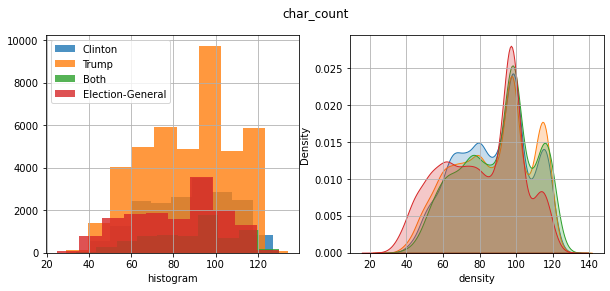

In [12]:
x, y = "char_count", "Keyword"
fig,ax = plot_distribution(x,y)
plt.show()

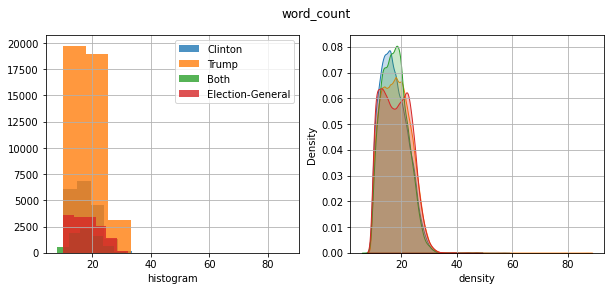

In [14]:
x, y = "word_count", "Keyword"
fig,ax = plot_distribution(x,y)
plt.show()

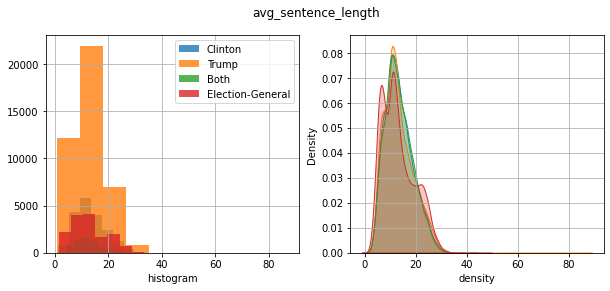

In [15]:
x, y = "avg_sentence_length", "Keyword"
fig,ax = plot_distribution(x,y)
plt.show()

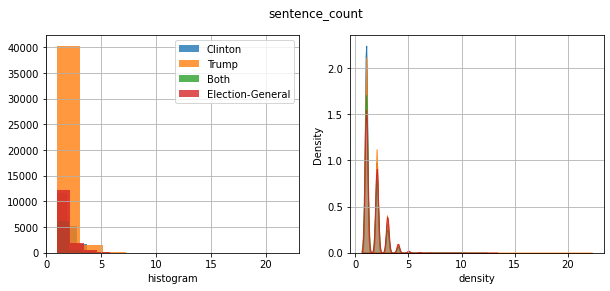

In [16]:
x, y = "sentence_count", "Keyword"
fig,ax = plot_distribution(x,y)
plt.show()

### 2. Sentiment Analysis

#### 2.1 Vader

In [13]:
analyzer = SentimentIntensityAnalyzer()

df2["sentiment_vader"] = df2['Text_Clean'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df2.head(3)

,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC,Text_Clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,sentiment_vader
0,Clinton,CrabbyAbbey1,2016-10-07 00:00:06+00:00,7.841815e+17,@SarahKSilverman If you have to lie to win you...,1,16,lie win work clinton that pretti deplor,16,82,2,5.125000,8.0,"{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'comp..."
1,Clinton,Marianne_Summer,2016-10-07 00:00:26+00:00,7.841816e+17,Here's how much Hillary Clinton paid in taxes ...,2,11,here much hillari clinton paid tax last year,11,49,1,4.454545,11.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Trump,SAcurrent,2016-10-07 00:00:32+00:00,7.841816e+17,Protesters at Trump's SA Fundraiser Were Passi...,78082,11,protest trump sa fundrais passion peac,11,62,1,5.636364,11.0,"{'neg': 0.222, 'neu': 0.444, 'pos': 0.333, 'co..."


#### 2.2 TextBlob

In [17]:
df2["sentiment"] = df2['Text_Clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
df2.head(3)

,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC,Text_Clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,sentiment
0,Clinton,CrabbyAbbey1,2016-10-07 00:00:06+00:00,7.841815e+17,@SarahKSilverman If you have to lie to win you...,1,16,lie win work clinton that pretti deplor,16,82,2,5.125000,8.0,0.8
1,Clinton,Marianne_Summer,2016-10-07 00:00:26+00:00,7.841816e+17,Here's how much Hillary Clinton paid in taxes ...,2,11,here much hillari clinton paid tax last year,11,49,1,4.454545,11.0,0.1
2,Trump,SAcurrent,2016-10-07 00:00:32+00:00,7.841816e+17,Protesters at Trump's SA Fundraiser Were Passi...,78082,11,protest trump sa fundrais passion peac,11,62,1,5.636364,11.0,0.0


In [ ]:
sentiment_col = "sentiment"

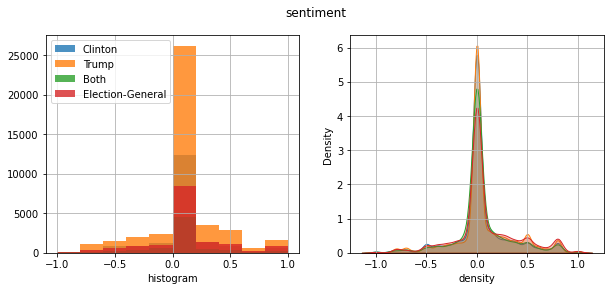

In [18]:
x, y = sentiment_col, "Keyword"
fig,ax = plot_distribution(x,y)
plt.show()

In [19]:
df2.groupby('Keyword')[sentiment_col].describe()

,count,mean,std,min,25%,50%,75%,max
Keyword,,,,,,,,
Both,7052.0,0.040446,0.276128,-1.0,0.0,0.0,0.100000,1.0
Clinton,18999.0,0.035836,0.279659,-1.0,0.0,0.0,0.068182,1.0
Election-General,14734.0,0.073691,0.318641,-1.0,0.0,0.0,0.200000,1.0
Trump,41862.0,0.058738,0.296486,-1.0,0.0,0.0,0.136364,1.0


In [20]:
# t test on whether there's difference on the sentiment of Trump VS Clinton
print(stats.ttest_ind(df2.loc[df2['Keyword']=='Trump',sentiment_col], df2.loc[df2['Keyword']=='Clinton',sentiment_col]))
print(stats.ttest_ind(df2.loc[df2['Keyword']=='Trump',sentiment_col], df2.loc[df2['Keyword']=='Clinton',sentiment_col],equal_var=False))

Ttest_indResult(statistic=8.986334585573342, pvalue=2.6271988646916943e-19)
Ttest_indResult(statistic=9.185570777439535, pvalue=4.2902677047367086e-20)


In [64]:
df2[['Followers',sentiment_col]].corr()

,Followers,sentiment
Followers,1.000000,0.001611
sentiment,0.001611,1.000000


In [65]:
sentiment_col_abs = f'{sentiment_col}_abs'
df2[sentiment_col_abs] = abs(df2[sentiment_col])
df2[['Followers',sentiment_col_abs]].corr()

,Followers,sentiment_abs
Followers,1.000000,-0.003919
sentiment_abs,-0.003919,1.000000


In [23]:
df2.groupby('Keyword')['Followers'].describe()

,count,mean,std,min,25%,50%,75%,max
Keyword,,,,,,,,
Both,7052.0,20937.130459,526466.557266,0.0,77.0,421.5,1805.5,30791230.0
Clinton,18999.0,9412.721564,328857.433726,0.0,96.0,500.0,1964.0,30730837.0
Election-General,14734.0,3756.097462,52380.240016,0.0,107.0,404.5,1427.0,5186908.0
Trump,41862.0,13554.278630,325661.135927,0.0,89.0,422.0,1703.0,30822080.0


In [24]:
# try to split the users posts by #followers they have
num_followers_list = df2.drop_duplicates(subset = 'Handle')['Followers']
q1, q3 = num_followers_list.quantile([.25,.75])
lower_boundary = q1-1.5*(q3-q1)
higher_boundary = q3+1.5*(q3-q1)
print(lower_boundary,higher_boundary)

-1852.0 3292.0


In [66]:
df2['group'] = '<1k followers'
df2.loc[df2['Followers']>=1e3,'group'] = '1k~100k followers'
df2.loc[df2['Followers']>=1e5,'group'] = '>=100k followers'

In [68]:
df2.groupby(['group'])[sentiment_col].describe().sort_values(by='count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
<1k followers,54030.0,0.055896,0.298842,-1.0,0.0,0.0,0.136364,1.0
1k~100k followers,27925.0,0.051843,0.288904,-1.0,0.0,0.0,0.125000,1.0
>=100k followers,692.0,0.062008,0.287355,-1.0,0.0,0.0,0.119886,1.0


In [70]:
df2.groupby(['group'])[sentiment_col_abs].describe().sort_values(by='count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
<1k followers,54030.0,0.175480,0.248268,0.0,0.0,0.0,0.300,1.0
1k~100k followers,27925.0,0.165027,0.242731,0.0,0.0,0.0,0.275,1.0
>=100k followers,692.0,0.158799,0.247325,0.0,0.0,0.0,0.250,1.0


In [71]:
df2.groupby(['Keyword','group'])[sentiment_col].describe().reset_index().sort_values(by=['Keyword','count'],ascending=[True,False])

,Keyword,group,count,mean,std,min,25%,50%,75%,max
1,Both,<1k followers,4571.0,0.038824,0.275737,-1.000,0.0,0.0,0.100000,1.0
0,Both,1k~100k followers,2378.0,0.042811,0.276874,-1.000,0.0,0.0,0.098214,1.0
2,Both,>=100k followers,103.0,0.057808,0.277904,-1.000,0.0,0.0,0.023485,1.0
4,Clinton,<1k followers,11843.0,0.037669,0.285110,-1.000,0.0,0.0,0.100000,1.0
3,Clinton,1k~100k followers,7023.0,0.033216,0.269730,-1.000,0.0,0.0,0.050000,1.0
5,Clinton,>=100k followers,133.0,0.010902,0.303418,-0.875,0.0,0.0,0.100000,0.8
7,Election-General,<1k followers,10085.0,0.072006,0.319887,-1.000,0.0,0.0,0.200000,1.0
6,Election-General,1k~100k followers,4586.0,0.076458,0.315850,-1.000,0.0,0.0,0.200000,1.0
8,Election-General,>=100k followers,63.0,0.142063,0.317093,-0.800,0.0,0.0,0.283333,1.0
10,Trump,<1k followers,27531.0,0.060671,0.299818,-1.000,0.0,0.0,0.136364,1.0


In [72]:
df2.groupby(['Keyword','group'])[sentiment_col_abs].describe().reset_index().sort_values(by=['Keyword','count'],ascending=[True,False])

,Keyword,group,count,mean,std,min,25%,50%,75%,max
1,Both,<1k followers,4571.0,0.153582,0.232263,0.0,0.0,0.000000,0.250000,1.000
0,Both,1k~100k followers,2378.0,0.151556,0.235614,0.0,0.0,0.000000,0.212500,1.000
2,Both,>=100k followers,103.0,0.140009,0.246598,0.0,0.0,0.000000,0.162500,1.000
4,Clinton,<1k followers,11843.0,0.159737,0.239142,0.0,0.0,0.000000,0.250000,1.000
3,Clinton,1k~100k followers,7023.0,0.144614,0.230091,0.0,0.0,0.000000,0.200000,1.000
5,Clinton,>=100k followers,133.0,0.174561,0.247951,0.0,0.0,0.000000,0.325000,0.875
7,Election-General,<1k followers,10085.0,0.200349,0.259555,0.0,0.0,0.066667,0.350000,1.000
6,Election-General,1k~100k followers,4586.0,0.195201,0.259801,0.0,0.0,0.050000,0.336458,1.000
8,Election-General,>=100k followers,63.0,0.200718,0.283051,0.0,0.0,0.033333,0.318750,1.000
10,Trump,<1k followers,27531.0,0.176779,0.249640,0.0,0.0,0.000000,0.300000,1.000


<AxesSubplot:xlabel='group', ylabel='sentiment'>

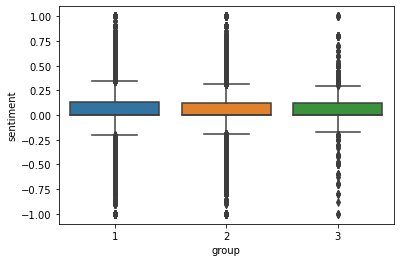

In [30]:
sns.boxplot(x = 'group',y = sentiment_col,data = df2)

<AxesSubplot:xlabel='Keyword', ylabel='Followers'>

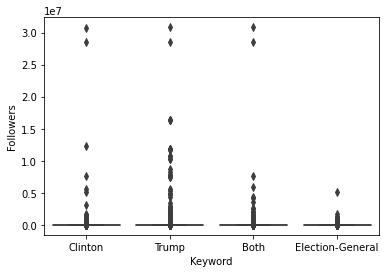

In [31]:
sns.boxplot(x = 'Keyword',y = 'Followers',data = df2)

In [32]:
# t test on whether there's difference on the number of followers of blogs talking about Trump VS Clinton
print(stats.ttest_ind(df2.loc[df2['Keyword']=='Trump','Followers'], df2.loc[df2['Keyword']=='Clinton','Followers']))
# print(stats.ttest_ind(df2.loc[df2['Keyword']=='Trump','Followers'], df2.loc[df2['Keyword']=='Clinton','Followers'],equal_var=False))

Ttest_indResult(statistic=1.449340736746415, pvalue=0.1472476026601166)
Ttest_indResult(statistic=1.4440328435697087, pvalue=0.14873834368875322)


### 3. Word vevtors

In [34]:
word = 'trump'
nlp = gensim_api.load("glove-wiki-gigaword-300")
nlp[word].shape

[==================================================] 100.0% 376.1/376.1MB downloaded


(300,)

In [36]:
def plot_word_vector(word,nlp):
    ## find closest vectors
    labels, X, x, y = [], [], [], []
    for t in nlp.most_similar(word, topn=20):
        X.append(nlp[t[0]])
        labels.append(t[0])
    ## reduce dimensions
    pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
    new_values = pca.fit_transform(X)
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    ## plot
    fig = plt.figure()
    for i in range(len(x)):
        plt.scatter(x[i], y[i], c="black")
        plt.annotate(labels[i], xy=(x[i],y[i]), xytext=(5,2), 
                textcoords='offset points', ha='right', va='bottom')
    ## add center
    plt.scatter(x=0, y=0, c="red")
    plt.annotate(word, xy=(0,0), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

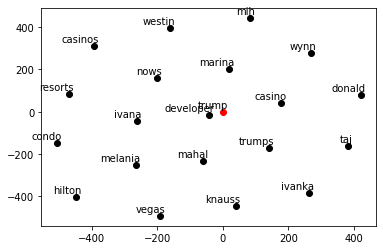

In [37]:
word = 'trump'
plot_word_vector(word,nlp)

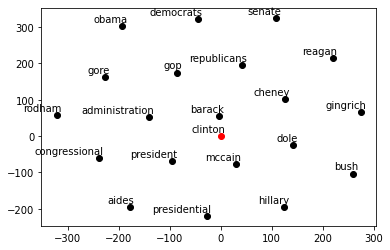

In [39]:
word = 'clinton'
plot_word_vector(word,nlp)

### 4. Topic models

In [59]:
cat = "Clinton"
processed_text = [nltk.word_tokenize(i) for i in df2.loc[df2['Keyword']==cat,'Text_Clean']]
# processed_text = [nltk.word_tokenize(i) for i in df2['Text_Clean']]

#create a dictionary of the words
dictionary = gensim.corpora.Dictionary(processed_text)
#create a TDM
doc_term_matrix = [dictionary.doc2bow(doc) for doc in processed_text]

['lie', 'win', 'work', 'clinton', 'that', 'pretti', 'deplor']

In [61]:
# build lda model
num_topics = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus = doc_term_matrix, #TDM
                                            id2word = dictionary, #Dictionary
                                            num_topics = num_topics, 
                                            random_state = 100,
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 10,
                                            alpha = 'auto',
                                            per_word_topics = True)

In [62]:
# create topic model viz
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary, n_jobs = 1)
pyLDAvis.save_html(vis, f'./output/LDA_Visualization_{num_topics}topics_{cat}.html') ##saves the file
# vis

# include plots
knitr::include_graphics('filename.png')